In [ ]:
# sphinx_gallery_thumbnail_number = 7

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

import os
from itertools import compress

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.preprocessing.nirs import optical_density, temporal_derivative_distribution_repair

from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed
from mne_nirs.visualisation import plot_timechannel_quality_metric
plt.ioff()


Channels marked as bad:
none


In [184]:
datapath = 'subjects/sub-17/ses-01/nirs'
raw_intensity = mne.io.read_raw_nirx(datapath).load_data()
#raw_intensity.load_data().resample(4.0, npad="auto")
#raw_od = optical_density(raw_intensity)
#raw_od.plot(n_channels=20, duration=500, show_scrollbars=False, clipping=None)

Loading subjects/sub-17/ses-01/nirs
Reading 0 ... 8117  =      0.000 ...  1558.464 secs...


C:\Users\sarab\AppData\Local\Temp\ipykernel_24616\1914234819.py:2: RuntimeWarning: Extraction of measurement date from NIRX file failed. This can be caused by files saved in certain locales (currently only ['en_US.utf8', 'de_DE', 'fr_FR', 'it_IT'] supported). Please report this as a github issue. The date is being set to January 1st, 2000, instead of '"20. feb 2025""12:51:47.652"'.
  raw_intensity = mne.io.read_raw_nirx(datapath).load_data()


In [185]:
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Noise", "3.0": "Speech", '4.0': 'XStop', '5.0': 'XStart'}
)

# annotation durations
raw_intensity.annotations.set_durations({'Control' : 5, 'Noise' : 5, 'Speech' : 5.25})

<Annotations | 67 segments: Control (20), Noise (20), Speech (20), XStart ...>

In [186]:
# Break events
Breaks, event_dict = mne.events_from_annotations(raw_intensity,{'XStop': 4, 'XStart': 5})
AllEvents, event_dict = mne.events_from_annotations(raw_intensity)
# Converting from index to time
Breaks = Breaks[:,0]/raw_intensity.info['sfreq']
LastEvent = AllEvents[-1,0]/raw_intensity.info['sfreq']


Used Annotations descriptions: [np.str_('XStart'), np.str_('XStop')]
Used Annotations descriptions: [np.str_('Control'), np.str_('Noise'), np.str_('Speech'), np.str_('XStart'), np.str_('XStop')]


In [187]:
# constructing block for each block in experiment
cropped_intensity = raw_intensity.copy().crop(Breaks[0],Breaks[1])
block2 = raw_intensity.copy().crop(Breaks[2],Breaks[3])
block3 = raw_intensity.copy().crop(Breaks[4],Breaks[5])
block4 = raw_intensity.copy().crop(Breaks[6], LastEvent+15.25)

# Combining all blocks
cropped_intensity.append([block2,block3,block4])
cropped_od = mne.preprocessing.nirs.optical_density(cropped_intensity)

In [188]:
cropped_corrected_od = temporal_derivative_distribution_repair(cropped_od)



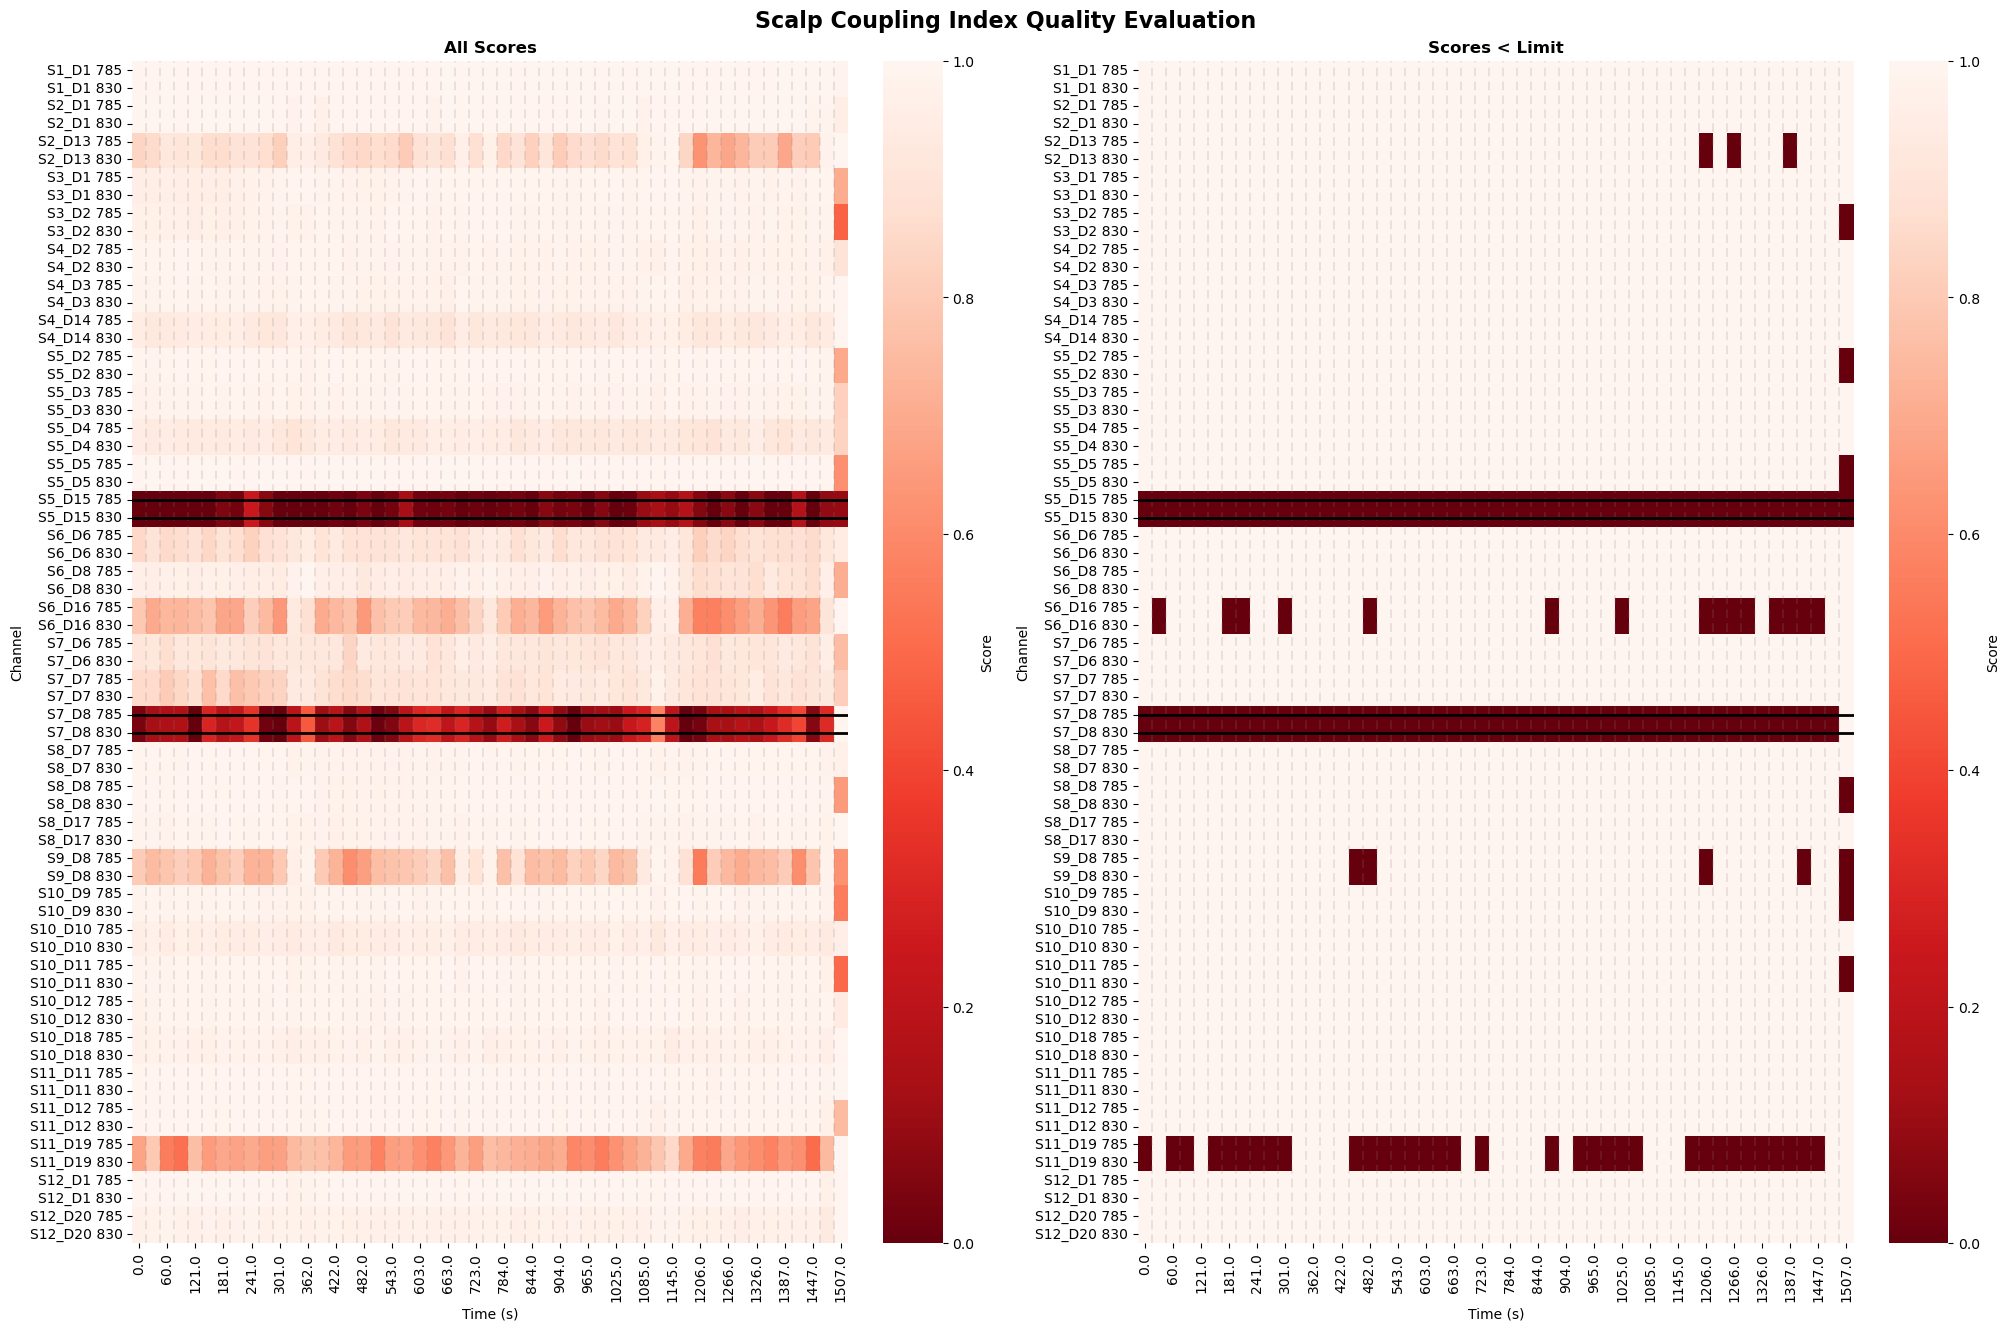

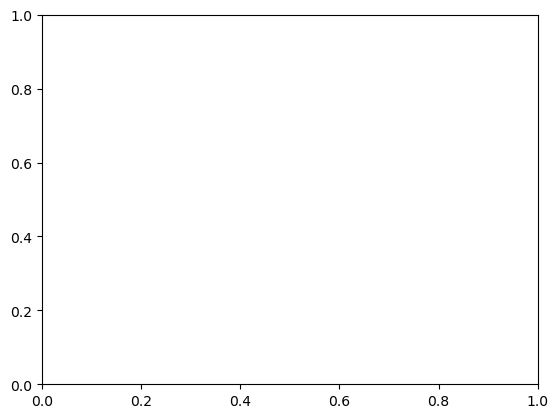

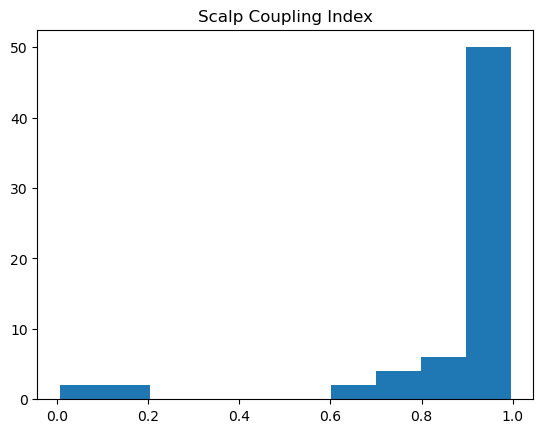

In [189]:
sci = mne.preprocessing.nirs.scalp_coupling_index(cropped_corrected_od)
fig, ax= plt.subplots()
ax.hist(sci)
ax.set_title('Scalp Coupling Index')
plt.show()

In [190]:
# remove break annotations
unwanted = np.nonzero(raw_intensity.annotations.description == 'XStart')
raw_intensity.annotations.delete(unwanted)
unwanted = np.nonzero(raw_intensity.annotations.description == 'XStop')
raw_intensity.annotations.delete(unwanted)

In [191]:
# remove also bad epoch list to be done

In [192]:
# convert again to optical density
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
corrected_od = temporal_derivative_distribution_repair(raw_od)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_od, ppf=6.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names),duration=500, show_scrollbars=False,show=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 393.216 (s)
Plotting power spectral density (dB=True).


C:\Users\sarab\AppData\Local\Temp\ipykernel_24616\2259084661.py:4: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.88)


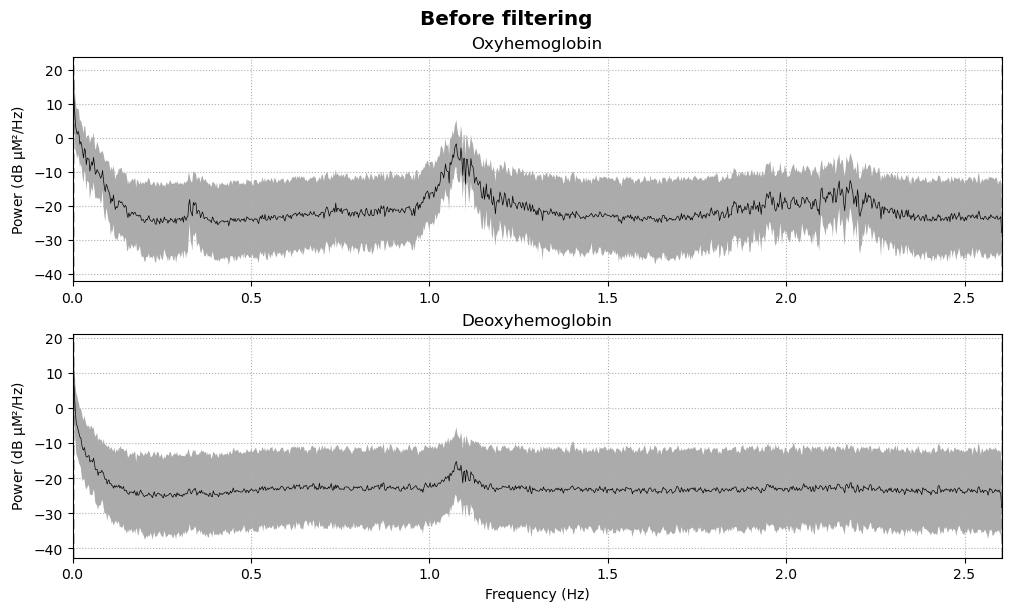

In [193]:
# pre-filtering
fig = raw_haemo.plot_psd(average=True,show=False)
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()

In [194]:
raw_haemo = raw_haemo.filter(l_freq = None, h_freq = 0.4, 
                                filter_length = 87, 
                                h_trans_bandwidth = 0.2, 
                                fir_window = 'hamming', 
                                fir_design = 'firwin')

raw_haemo = raw_haemo.filter(0.05, h_freq = None, l_trans_bandwidth=0.02)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.40 Hz


- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 87 samples (16.704 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.05 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Filter length: 861 samples (165.312 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 393.216 (s)
Plotting power spectral density (dB=True).


C:\Users\sarab\AppData\Local\Temp\ipykernel_24616\1037655273.py:4: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.88)


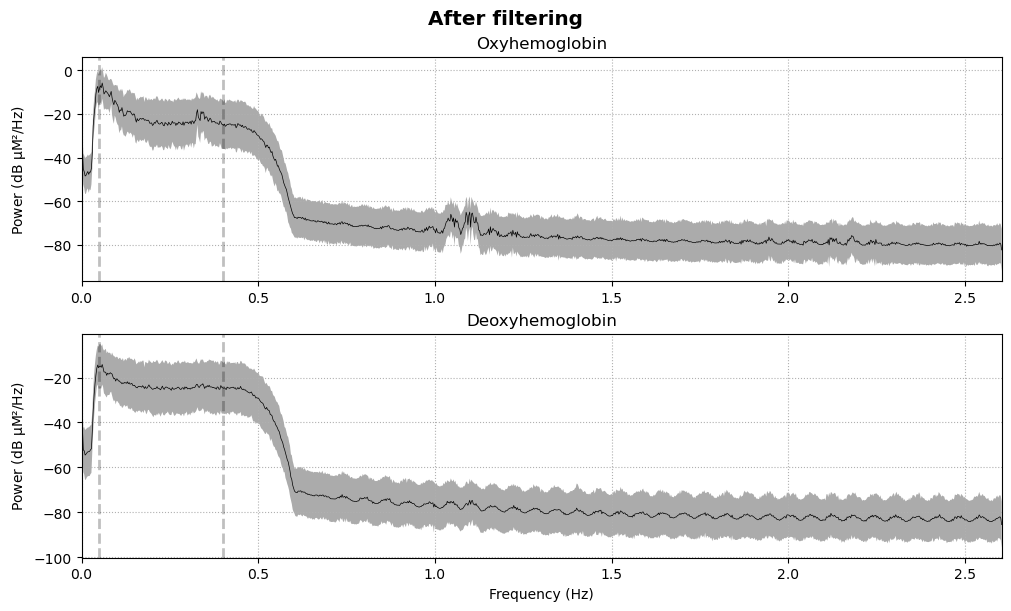

In [195]:
# post-filtering
fig = raw_haemo.plot_psd(average=True,show=False)
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()


#raw_haemo.plot(n_channels=len(raw_haemo.ch_names),duration=500, show_scrollbars=False,show=True)

In [196]:
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
print(raw_od.info["bads"])
len(raw_od.info["bads"])


['S5_D15 785', 'S5_D15 830', 'S7_D8 785', 'S7_D8 830']


4

Show the bad channels

In [176]:
#raw_od.plot(n_channels=55, duration=500, show_scrollbars=False, clipping=None)

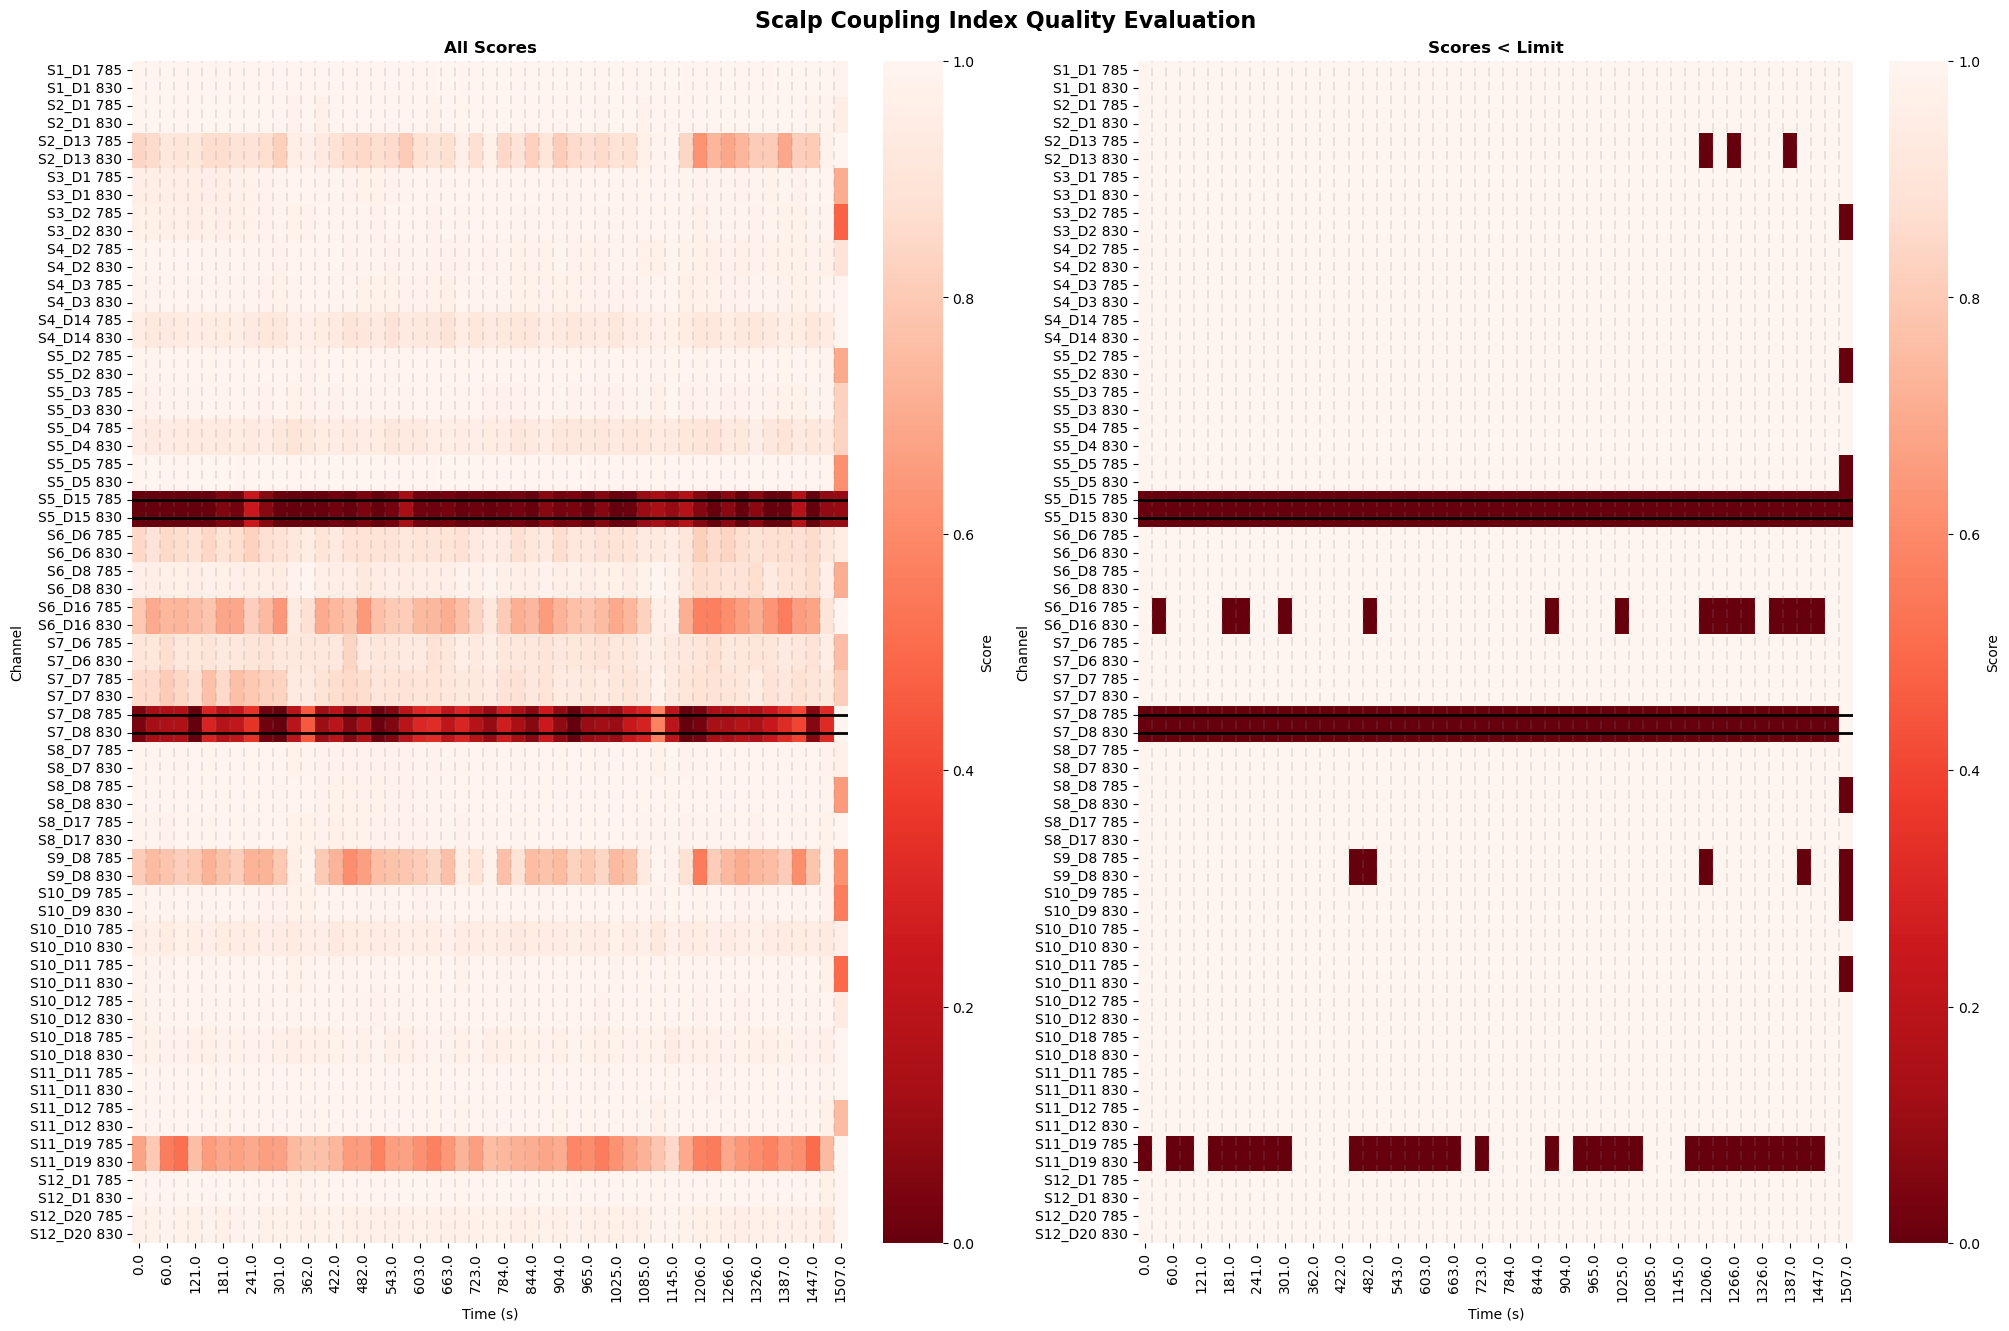

In [177]:

_, scores, times = scalp_coupling_index_windowed(raw_od, time_window=30)
plot_timechannel_quality_metric(
    raw_od,
    scores,
    times,
    threshold=0.7,
    title="Scalp Coupling Index " "Quality Evaluation",
)


In [204]:
import pandas as pd
from collections import Counter

def top_bad_channels(csv_path, top_x):
    # Load the CSV file
    df = pd.read_csv(csv_path)
    
    # Convert the 'Bad_Channels' column from string to list
    df['Bad_Channels'] = df['Bad_Channels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    # Flatten the list of all bad channels
    all_bad_channels = [channel for sublist in df['Bad_Channels'] for channel in sublist]
    
    # Count occurrences of each channel
    channel_counts = Counter(all_bad_channels)
    
    # Get the top X most common bad channels
    top_channels = channel_counts.most_common(top_x)
    
    # Display results
    print(f"Top {top_x} most repeated bad channels:")
    for channel, count in top_channels:
        print(f"{channel}: {count} occurrences")

# Example usage
top_bad_channels('bad_channels_summary.csv', 66)


Top 66 most repeated bad channels:
S4_D14 785: 27 occurrences
S4_D14 830: 27 occurrences
S5_D15 785: 27 occurrences
S5_D15 830: 27 occurrences
S6_D16 785: 27 occurrences
S6_D16 830: 27 occurrences
S10_D18 785: 24 occurrences
S10_D18 830: 24 occurrences
S8_D17 785: 22 occurrences
S8_D17 830: 22 occurrences
S11_D19 785: 18 occurrences
S11_D19 830: 18 occurrences
S7_D8 785: 15 occurrences
S7_D8 830: 15 occurrences
S2_D13 785: 15 occurrences
S2_D13 830: 15 occurrences
S6_D6 785: 15 occurrences
S6_D6 830: 15 occurrences
S12_D20 785: 14 occurrences
S12_D20 830: 14 occurrences
S7_D6 785: 13 occurrences
S7_D6 830: 13 occurrences
S8_D7 785: 12 occurrences
S8_D7 830: 12 occurrences
S9_D8 785: 12 occurrences
S9_D8 830: 12 occurrences
S5_D3 785: 10 occurrences
S5_D3 830: 10 occurrences
S7_D7 785: 10 occurrences
S7_D7 830: 10 occurrences
S8_D8 785: 9 occurrences
S8_D8 830: 9 occurrences
S6_D8 785: 8 occurrences
S6_D8 830: 8 occurrences
S10_D9 785: 7 occurrences
S10_D9 830: 7 occurrences
S4_D2 785: 

Channels marked as bad:
none
